# Deep Learning &mdash; Assignment 1

First assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----
**Names:**

- Daan Brugmans
- Maximilian Pohl

**Group:**
31
-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Experiment with gradient descent optimization;
2. Derive and implement gradients for binary cross-entropy loss, the sigmoid function and a linear layer;
3. Test your gradient implementations with the finite difference method;
4. Use these components to implement and train a simple neural network.

In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize
import sklearn.datasets
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=6, linewidth=200)
plt.style.use('ggplot')

## 1.1 Gradient descent optimization (6 points)

Consider the following function with two parameters and its derivatives:

$$
\begin{align}
  f(x, y) &= x^2 + y^2 + x (y + 2) + \cos(3x) \\
  \frac{\partial f}{\partial x} &= 2x - 3\sin(3x) + y + 2 \\
  \frac{\partial f}{\partial y} &= x + 2y \\
\end{align}
$$

In [2]:
def f(x, y):
    return x ** 2 + y ** 2 + x * (y + 2) + np.cos(3 * x)


def grad_x_f(x, y):
    return 2 * x - 3 * np.sin(3 * x) + y + 2


def grad_y_f(x, y):
    return x + 2 * y

A plot of the function shows that it has multiple local minima:

In [3]:
def plot_f_contours():
    xx, yy = np.meshgrid(np.linspace(-5, 5), np.linspace(-5, 5))
    zz = f(xx, yy)
    plt.contourf(xx, yy, zz, 50)
    plt.contour(xx, yy, zz, 50, alpha=0.2, colors='black', linestyles='solid')
    plt.xlabel('x')
    plt.ylabel('y')


plt.figure(figsize=(10, 7))
plot_f_contours()

### Implement gradient descent

We would like to find the minimum of this function using gradient descent.

**(a) Implement the gradient descent updates for $x$ and $y$ in the function below:<span style="float:right"> (1 point)</span>**

In [4]:
def optimize_f(x, y, step_size, steps):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at the current point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - step_size * dx
        y = y - step_size * dy

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

In [5]:
# The following assert statements check that your implementation behaves sensibly
# Use it to get a hint only if you are stuck.
assert optimize_f(3, 2, 0.1, 1)[0] != 3, "Hint: you are not changing `x`"
assert optimize_f(3, 2, 0.1, 1)[2] < f(3,
                                       2), "Hint: the function value is increasing, you should be minimizing it, not maximizing."
assert abs(optimize_f(3, 2, 0.1, 1)[0] - 3) < 1, "Hint: you are probably taking steps that are too large."

### Tune the parameters

We will now try if our optimization method works.

Use this helper function to plot the results:

In [6]:
# helper function that plots the results of the gradient descent optimization
def plot_gradient_descent_results(x, y, val, x_hist, y_hist):
    # plot the path on the contour plot
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plot_f_contours()
    plt.plot(x_hist, y_hist, '.-')

    # plot the learning curve
    plt.subplot(1, 2, 2)
    plt.plot(f(np.array(x_hist), np.array(y_hist)), '.r-')
    plt.title('Minimum value: %f' % f(x_hist[-1], y_hist[-1]))

**(b) Run the gradient descent optimization with the following initial settings:**

``x=3, y=2, step_size=0.1, steps=10``

In [7]:
results = optimize_f(x=3, y=2, step_size=0.1, steps=10)
plot_gradient_descent_results(*results)

**(c) Does it find the minimum of the function? What happens?<span style="float:right"> (1 point)</span>**

It does not find the global minimum as it gets stuck in some local minimum.

**(d) Try a few different values for the `step_size` and the number of `steps` to get close to the optimal solution:**

In [8]:
results = optimize_f(x=3, y=2, step_size=0.305, steps=13)
plot_gradient_descent_results(*results)

**(e) What happens if you set the step size too small? And what if it is too large?<span style="float:right"> (1 point)</span>**

If the step size is too small, we get stuck in a small, local minimum and cannot evade it. Additionally, it requires more steps, e.g., more computation time.

If the step size is too large, we don't get any reasonable result, as it hops back and forth the whole search area. This is visible in the left visualization and by the fact that the loss (in the right image) goes all the way up and down all the time.

**(f) Were you able to find a step size that reached the global optimum? If not, why not?<span style="float:right"> (1 point)</span>**

No, we have not been able to find hyper-parameters that reach the global minimum, as the search either got stuck in the local minimum if the step size was too small, of shot over the optimum, if the step size was bigger.

### Implement a decreasing step size

You might get better results if you use a step size that is large at the beginning, but slowly decreases during the optimization.

Try the following scheme to compute the step size $\eta_t$ in step $t$, given a decay parameter $d$:

$$
\begin{align}
  \eta_t = \eta_0 d^t
\end{align}
$$

**(g) Update your optimization function to use this step size schedule:<span style="float:right"> (1 point)</span>**

In [9]:
def optimize_f(x, y, step_size, steps, decay=1.0):
    # keep track of the parameters we tried so far
    x_hist, y_hist = [x], [y]

    # run gradient descent for the number of steps
    for step in range(steps):
        # compute the gradients at this point
        dx = grad_x_f(x, y)
        dy = grad_y_f(x, y)

        # apply the gradient descent updates to x and y
        x = x - (step_size * decay ** step) * dx
        y = y - (step_size * decay ** step) * dy

        # store the new parameters
        x_hist.append(x)
        y_hist.append(y)

    return x, y, f(x, y), x_hist, y_hist

In [10]:
# The following assert statement checks that your implementation behaves sensibly
_trace = optimize_f(0.123, 0.456, 0.01, 2, 0.1)[3]
assert abs(_trace[1] - _trace[0]) > 5 * abs(_trace[2] - _trace[1]), "Hint: step size should be decreasing"
del _trace

**(h) Tune the `step_sizes`, `steps` and `decay` parameters to get closer to the global minimum:<span style="float:right"> (1 point)</span>**

In [11]:
results = optimize_f(x=3, y=2, step_size=0.2, steps=10, decay=0.8)
plot_gradient_descent_results(*results)

In [12]:
assert results[2] < -2, "Hint: get closer to the optimum"

We will now look at some more complex functions that we can try to optimize.

## 1.2 Neural network components (16 points)

In this assignment, we will implement a simple neural network from scratch. We need four components:
1. A sigmoid activation function,
2. A ReLU activation function,
3. A binary cross-entropy loss function,
4. A linear layer.

For each component, we will implement the forward pass, the backward pass, and the gradient descent update.

### Sigmoid non-linearity

The sigmoid function is defined as:

$$
\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
\end{align}
$$

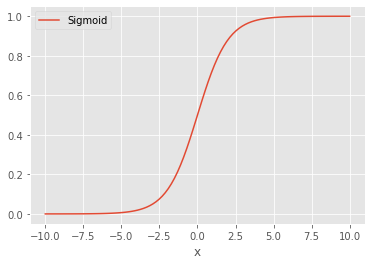

**(a) Give the derivative of the sigmoid function:<span style="float:right"> (1 point)</span>**

\begin{align}
\frac{\partial \sigma(x)}{\partial x} &= \frac{e^{-x}}{(1+e^{-x})^2}
\end{align}

**(b) Implement the sigmoid and its gradient in the functions `sigmoid(x)` and `sigmoid_grad(x)`:<span style="float:right"> (2 points)</span>**

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return np.exp(-x) / ((1 + np.exp(-x)) ** 2)


# try with a random input
rng = np.random.default_rng(12345)
x = rng.uniform(-10, 10, size=5)
print('x:', x)
print('sigmoid(x):', sigmoid(x))
print('sigmoid_grad(x):', sigmoid_grad(x))

x: [-5.45328  -3.664833  5.947309  3.525093 -2.177809]
sigmoid(x): [0.004264 0.024969 0.997394 0.971393 0.101761]
sigmoid_grad(x): [0.004246 0.024346 0.002599 0.027788 0.091406]


To check that the gradient implementation is correct, we can compute the numerical derivative using the [finite difference](https://en.wikipedia.org/wiki/Finite_difference) method. From [Chapter 11.5 of the Deep Learning book](http://www.deeplearningbook.org/contents/guidelines.html):

> Because
  \begin{align}
    f'(x) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{ \epsilon},
  \end{align}
  we can approximate the derivative by using a small, finite $\epsilon$:
  \begin{align}
    f'(x) \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}.
  \end{align}
  We can improve the accuracy of the approximation by using the centered difference:
  \begin{align}
    f'(x) \approx \frac{f(x + \frac{1}{2} \epsilon) - f(x - \frac{1}{2} \epsilon)}{\epsilon}.
  \end{align}
  The perturbation size $\epsilon$ must be large enough to ensure that the perturbation is not rounded down too much by ﬁnite-precision numerical computations.

**(c) Use the central difference method to check your implementation of the sigmoid gradient. Compute the numerical gradient and check that it is close to the symbolic gradient computed by your implementation:<span style="float:right"> (1 point)</span>**

In [14]:
# start with some random inputs
rng = np.random.default_rng(12345)
x = rng.uniform(-2, 2, size=5)

# compute the symbolic gradient
print('Symbolic ', sigmoid_grad(x))

eps_half = 0.00001
num_gradient = (sigmoid(x + eps_half) - sigmoid(x - eps_half)) / (2 * eps_half)
print('Numerical', num_gradient)

Symbolic  [0.188245 0.219215 0.178901 0.221338 0.238508]
Numerical [0.188245 0.219215 0.178901 0.221338 0.238508]


**(d) Is the gradient computed with finite differences exactly the same as the analytic answer? Why (not)?<span style="float:right"> (1 point)</span>**

Depending on the value of $\epsilon$, the numerical value gets very close to the symbolic one. If $\epsilon$ gets too big, the approximation is inaccurate, if it gets too small, the approximation gets more inaccurate again, as we get problems with the floating point representation. 

**If there is a big difference between the two gradients, please try to make this as small as possible before you continue.**

### Rectified linear units (ReLU)

The rectified linear unit is defined as:
$$
\begin{align}
  f(x) = \max(0, x)
\end{align}
$$
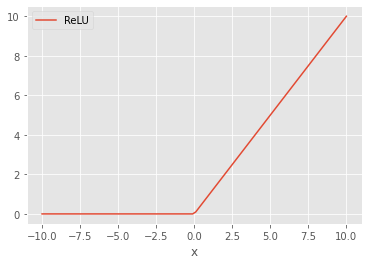

**(e) Give the derivative of the ReLU function:<span style="float:right"> (1 point)</span>**

Note: this gradient is not well-defined everywhere, but make a sensible choice for all values of $x$.

$$
\begin{align}
  \frac{\partial f(x)}{\partial x} &= \begin{cases}
                                        1 & \text{if } x \geq 0 \\
                                        0 & \text{if } x < 0
                                      \end{cases}
\end{align}
$$

**(f) Implement the ReLU function and its gradient in the functions `relu(x)` and `relu_grad(x)`. Use the finite difference method to check that the gradient is correct:<span style="float:right"> (2 points)</span>**

In [15]:
def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    return (x > 0) * 1


# try with a random input
rng = np.random.default_rng(12345)
x = rng.uniform(-10, 10, size=5)
print('x:', x)
print('relu(x):', relu(x))
print('relu_grad(x):', relu_grad(x))
print()

eps_half = 0.00001
num_gradient = (relu(x + eps_half) - relu(x - eps_half)) / (2 * eps_half)
print('Numerical', num_gradient)

x: [-5.45328  -3.664833  5.947309  3.525093 -2.177809]
relu(x): [0.       0.       5.947309 3.525093 0.      ]
relu_grad(x): [0 0 1 1 0]

Numerical [0. 0. 1. 1. 0.]


### Comparing sigmoid and ReLU

The sigmoid and ReLU activation functions have slightly different characteristics.

**(g) Run the code below to plot the sigmoid and ReLU activation functions and their gradients:**

In [16]:
x = np.linspace(-10, 10, 100)

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(x, relu(x), label='ReLU')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(x, sigmoid_grad(x), label='Sigmoid gradient')
plt.xlabel('x')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(x, relu_grad(x), label='ReLU gradient')
plt.xlabel('x')
plt.legend(loc='upper left');

**(h) Which activation function would you recommend for a network that outputs probabilities, i.e., outputs $\in [0, 1]$? Why?<span style="float:right"> (1 point)</span>**

We would use the Sigmoid activation function, as it outputs a value between 0 and 1. The ReLU, instead, may output any number bigger than 0, which cannot be easily mapped to a probabaility, without knowing the maximum value.

**(i) Compare the gradients for sigmoid and ReLU. What are the advantages and disadvantages of each activation function in terms of their gradient?<span style="float:right"> (1 point)</span>**

The ReLU gradient is very easy to compute, while the Sigmoid gradient takes a bit more computational resources. On the other hand, the Sigmoid gradient is a coninouse, while the ReLU gradient isn't.

### Binary cross-entropy loss

We will use the binary cross-entropy loss to train our network. This loss function is useful for binary classification.

The binary cross-entropy (BCE) is a function of the ground truth label $y \in \{0, 1\}$ and the predicted label $\hat{y} \in [0, 1]$:
$$
\begin{align}
  \mathcal{L} &= -(y \log{\hat{y}} + (1-y) \log(1-\hat{y})) \\
\end{align}
$$
To minimize the BCE loss with gradient descent, we need to compute the gradient with respect to the prediction $\hat{y}$.

**(j) Derive the gradient for the BCE loss:<span style="float:right"> (1 point)</span>**

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{y}} &= \frac{1-y}{1-\hat{y}}-\frac{y}{\hat{y}} \\
 &= \frac{\hat{y}-y}{\hat{y}-\hat{y}^2}
\end{align}
$$

**(k) Implement `bce_loss(y, y_hat)` and `bce_loss_grad(y, y_hat)` and use the finite difference method to check that the gradient is correct:<span style="float:right"> (3 points)</span>**

In [17]:
def bce_loss(y, y_hat):
    return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))


def bce_loss_grad(y, y_hat):
    return (y_hat - y) / (y_hat - y_hat ** 2)


# try with some random inputs
rng = np.random.default_rng(12345)
y = rng.integers(2, size=5)
y_hat = rng.uniform(0, 1, size=5)
print('y:', y)
print('y_hat:', y_hat)
print('bceloss(y, y_hat):', bce_loss(y, y_hat))
print('bceloss_grad(y, y_hat):', bce_loss_grad(y, y_hat))
print()

eps_half = 0.00001
num_gradient = (bce_loss(y, y_hat + eps_half) - bce_loss(y, y_hat - eps_half)) / (2 * eps_half)
print('Numerical', num_gradient)

y: [1 0 1 0 0]
y_hat: [0.676255 0.39111  0.332814 0.598309 0.186734]
bceloss(y, y_hat): [0.391186 0.496117 1.100172 0.912072 0.206697]
bceloss_grad(y, y_hat): [-1.478733  1.642332 -3.004682  2.489474  1.22961 ]

Numerical [-1.478733  1.642332 -3.004682  2.489474  1.22961 ]


### Linear layer

Finally, we need to compute the gradients for the linear layer in our network.

Define a linear model $\mathbf{y} = \mathbf{x} \mathbf{W} + \mathbf{b}$, where
* $\mathbf{x}$ is an input vector of shape $N$,
* $\mathbf{W}$ is a weight matrix of shape $N \times M$,
* $\mathbf{b}$ is a bias vector of shape $M$,
* $\mathbf{y}$ is the output vector of shape $M$.

**(l) Derive the gradients for $\mathbf{y}$ with respect to the input $\mathbf{x}$ and the parameters $\mathbf{W}$ and $\mathbf{b}$:<span style="float:right"> (1 point)</span>**

_Hint: If you have trouble computing this in matrix notation directly, try to do the computation with scalars, writing the linear model as_
$$
\begin{align}
  y_j = \sum_{i=1}^{N} x_i W_{ij} + b_j
\end{align}
$$
where $j$ ranges from $1$ to $M$.

$$
\begin{align}
  \frac{\partial y_j}{\partial x_i} &= W_{i, j} &
  \frac{\partial y_j}{\partial W_{ik}} &= \begin{cases}
                                            0 & \text{if } j = k \\
                                            x_i & \text{if } j \neq k \\
                                          \end{cases} &
  \frac{\partial y_j}{\partial b_k} &= 1 \\
\end{align}
$$
or
$$
\begin{align}
  \frac{\partial \mathbf{y}}{\partial \mathbf{x}} &= \mathbf{W} &
  \frac{\partial \mathbf{y}}{\partial \mathbf{W}} &=  \text{Some 3rd order tensor} &
  \frac{\partial \mathbf{y}}{\partial \mathbf{b}} &= I \\
\end{align}
$$
(keep only one)

**(m) Given the gradient $\nabla_\mathbf{y} \mathcal{L}$ for the loss w.r.t. $\mathbf{y}$, use the chain rule to derive the gradients for the loss w.r.t. $\mathbf{x}$, $\mathbf{W}$ and $\mathbf{b}$:<span style="float:right"> (1 point)</span>**

$$
\begin{align}
  \nabla_\mathbf{x} \mathcal{L} &= \nabla_\mathbf{y} \mathcal{L} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \nabla_\mathbf{y} \mathcal{L} \cdot \mathbf{W} \\
  \nabla_\mathbf{W} \mathcal{L} &= \nabla_\mathbf{y} \mathcal{L} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{W}} = \nabla_\mathbf{y} \mathcal{L} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{W}} \\
  \nabla_\mathbf{b} \mathcal{L} &= \nabla_\mathbf{y} \mathcal{L} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{b}} = \nabla_\mathbf{y} \mathcal{L}\\
\end{align}
$$

## 1.3 Implement a one-layer model (2 points)

We can now implement a simple one-layer model with a sigmoid activation:

1. Given an input vector $\mathbf{x}$, weight vector $\mathbf{w}$ and bias $b$, compute the output $\hat{y}$:

$$
\begin{align}
h = \mathbf{x} \mathbf{w}^T + b \\
\hat{y} = \sigma(h) \\
\end{align}
$$

2. Compute the BCE loss comparing the prediction $\hat{y}$ with the ground-truth label $y$.

3. Compute the gradient for the BCE loss and back-propagate this to get $\nabla_\mathbf{x} \mathcal{L}$, the gradient of $\mathcal{L}$ w.r.t. $\mathbf{x}$.

Hint: in numpy inner product and matrix multiplication is denoted as `np.dot(A, B)` or as `A @ B`.

**(a) Complete the implementation below:<span style="float:right"> (2 points)</span>**

In [18]:
# initialize parameters
rng = np.random.default_rng(12345)
w = rng.normal(size=5)
b = rng.normal()


# implement the model
def fn(x, y):
    # forward: compute h, y_hat, loss
    h = x @ w + b
    y_hat = sigmoid(h)
    loss = bce_loss(y, y_hat)

    # backward: compute grad_y_hat, grad_h, grad_x
    grad_y_hat = sigmoid_grad(h)
    grad_h = w
    grad_x = bce_loss_grad(y, y_hat) * grad_y_hat * grad_h

    return loss, grad_x


# test with a random input
x = rng.uniform(size=5)
y = 1

loss, grad_x = fn(x, y)
print("Loss", loss)
print("Gradient", grad_x)

assert np.isscalar(loss), "Loss should be scalar"
assert grad_x.shape == x.shape, "Gradient should have same shape as x"

Loss 2.309880244091049
Gradient [ 1.282477 -1.138274  0.784228  0.233444  0.067864]


**(b) Use the finite-difference method to check the gradient $\nabla_\mathbf{x} \mathcal{L}$:**

In [19]:
# start with some random inputs
rng = np.random.default_rng(12345)
x = rng.uniform(size=5)
y = 1

# set epsilon to a small value
eps_half = 0.00001

numerical_grad = np.zeros(x.shape)
# compute the gradient for each element of x separately
for i in range(len(x)):
    # compute inputs at -eps/2 and +eps/2
    x_a, x_b = x.copy(), x.copy()
    x_a[i] += eps_half / 2
    x_b[i] -= eps_half / 2

    # compute the gradient for this element
    loss_a, _ = fn(x_a, y)
    loss_b, _ = fn(x_b, y)
    numerical_grad[i] = (loss_a - loss_b) / eps_half

# compute the symbolic gradient
loss, symbolic_grad = fn(x, y)

print("Symbolic gradient")
print(symbolic_grad)
print("Numerical gradient")
print(numerical_grad)

Symbolic gradient
[ 1.177245 -1.044874  0.719879  0.214289  0.062295]
Numerical gradient
[ 1.177245 -1.044874  0.719879  0.214289  0.062295]


## 1.4 Implement a linear layer and the sigmoid and ReLU activation functions (5 points)

We will now construct a simple neural network. We need to implement the following objects:
* `Linear`: a layer that computes `y = x*W + b`.
* `Sigmoid`: a layer that computes `y = sigmoid(x)`.
* `ReLU`: a layer that computes `y = relu(x)`.

For each layer class, we need to implement the following methods:
* `forward`: The forward pass that computes the output `y` given `x`.
* `backward`: The backward pass that receives the gradient for `y` and computes the gradients for the input `x` and the parameters of the layer.
* `step`: The update step that applies the gradient updates to the parameters of the layer, based on the gradient computed and stored by `backward`.

**(a) Implement a class `Linear` that computes `y = x*W + b`:<span style="float:right"> (3 points)</span>**

In [20]:
# Computes y = x * w + b.
class Linear:
    def __init__(self, n_in, n_out, rng=np.random.default_rng(12345)):
        # initialize the weights randomly,
        # using the Xavier initialization rule for scale
        a = np.sqrt(6 / (n_in * n_out))
        self.W = rng.uniform(-a, a, size=(n_in, n_out))
        self.b = np.zeros((n_out,))

    def forward(self, x):
        y = x @ self.W + self.b
        return y

    def backward(self, x, dy):
        # given dy, compute the gradients for x, W and b
        dx = dy @ self.W.T
        self.dW = x.T @ dy
        self.db = np.ones(dy.shape[0]) @ dy
        return dx

    def step(self, step_size):
        # apply a gradient descent update step
        self.W = self.W - (step_size * self.dW)
        self.b = self.b - (step_size * self.db)

    def __str__(self):
        return 'Linear %dx%d' % self.W.shape


# Try the new class with some random values.
# Debugging tip: always choose a unique length for each dimension,
#  so you'll get an error if you mix them up.
rng = np.random.default_rng(12345)
x = rng.uniform(size=(3, 5))

layer = Linear(5, 7, rng=rng)
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

# Verify correctness
assert y.shape == (3, 7)
assert dx.shape == x.shape
layer.W *= 2
layer.b = layer.b * 2 + 1
y2 = layer.forward(x)
dx2 = layer.backward(x, np.ones_like(y))
assert np.all(y2 == 2 * y + 1)
assert np.all(dx2 == 2 * dx)

y: [[ 0.252427  0.428688 -0.081518  0.207314 -0.058535 -0.005779  0.059303]
 [ 0.382911  0.146397 -0.275544 -0.026378 -0.333927 -0.537221 -0.223564]
 [ 0.15955   0.155119 -0.222059  0.428698 -0.231045 -0.345936 -0.119919]]
dx: [[-0.326296 -0.992105  1.657474  0.165888 -0.622481]
 [-0.326296 -0.992105  1.657474  0.165888 -0.622481]
 [-0.326296 -0.992105  1.657474  0.165888 -0.622481]]


**(b) Implement a class `Sigmoid` that computes `y = 1 / (1 + exp(-x))`:<span style="float:right"> (1 point)</span>**

In [21]:
# Computes y = 1 / (1 + exp(-x)).
class Sigmoid:
    def forward(self, x):
        # compute the forward pass
        return sigmoid(x)

    def backward(self, x, dy):
        # compute the backward pass,
        # return the gradient for x given the gradient for y
        return sigmoid_grad(x) * dy

    def step(self, step_size):
        # raise NotImplementedError
        pass

    def __str__(self):
        return 'Sigmoid'


# try the new class with some random values
rng = np.random.default_rng(12345)
x = rng.normal(size=(3, 5))

layer = Sigmoid()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

assert y.shape == x.shape, "Output sigmoid should have the same shape as input"
assert dx.shape == x.shape, "Gradient sigmoid should have the same shape as input"
assert np.all(y > 0) and np.all(y < 1), "Output of sigmoid should be between 0 and 1"

y: [[0.194063 0.779667 0.295117 0.435567 0.481173]
 [0.322811 0.202977 0.656761 0.589297 0.124242]
 [0.912728 0.72482  0.318779 0.711401 0.385338]]
dx: [[0.156402 0.171786 0.208023 0.245848 0.249646]
 [0.218604 0.161777 0.225426 0.242026 0.108806]
 [0.079656 0.199456 0.217159 0.20531  0.236853]]


**(c) Implement a class `ReLU` that computes `y = max(0, x)`:<span style="float:right"> (1 point)</span>**

In [22]:
# Computes y = max(0, x).
class ReLU:
    def forward(self, x):
        # compute the forward pass
        return relu(x)

    def backward(self, x, dy):
        # compute the backward pass,
        # return the gradient for x given dy
        return relu_grad(x) * dy
    
    def step(self, step_size):
        pass

    def __str__(self):
        return 'ReLU'


# try the new class with some random values
rng = np.random.default_rng(12345)
x = rng.uniform(-10, 10, size=(3, 5))

layer = ReLU()
y = layer.forward(x)
dx = layer.backward(x, np.ones_like(y))
print('y:', y)
print('dx:', dx)

assert y.shape == x.shape, "Output of ReLU should have the same shape as input"
assert dx.shape == x.shape, "Gradient of ReLU should have the same shape as input"

y: [[0.       0.       5.947309 3.525093 0.      ]
 [0.       1.966175 0.       3.455121 8.836057]
 [0.       8.977623 3.344749 0.       0.      ]]
dx: [[0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0.]]


### Verify the gradients

The code below will check your implementations using SciPy's finite difference implementation [`check_grad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html). This is similar to what we did manually before, but automates some of the work.

**(d) Run the code and check that the error is not too large.**

In [23]:
## Verify gradient computations for Linear
# test for dx
rng = np.random.default_rng(12345)
layer = Linear(5, 7, rng)


def test_fn(x):
    x = x.reshape(3, 5)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))


def test_fn_grad(x):
    x = x.reshape(3, 5)
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones((3, 7))).flatten()


err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=3 * 5))
print("err on dx:", err)
assert np.abs(err) < 1e-5, "Error on dx is too large, check your implementation of Linear.backward."

# test for dW
x = rng.uniform(size=(3, 5))
layer = Linear(5, 7, rng)


def test_fn(w):
    layer.W = w.reshape(5, 7)
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))


def test_fn_grad(w):
    layer.W = w.reshape(5, 7)
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((3, 7)))
    return layer.dW.flatten()


err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=5 * 7))
print("err on dW:", err)
assert np.abs(err) < 1e-5, "Error on dW is too large, check your implementation of Linear.backward."

# test for db
x = rng.uniform(size=(3, 5,))
layer = Linear(5, 7, rng)


def test_fn(b):
    layer.b = b
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))


def test_fn_grad(b):
    layer.b = b
    # multiply the incoming dy gradient with a constant
    layer.backward(x, 2 * np.ones((x.shape[0], 7)))
    return layer.db


err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=7))
print("err on db:", err)
assert np.abs(err) < 1e-5, "Error on db is too large, check your implementation of Linear.backward."

err on dx: 8.877935602122721e-07
err on dW: 1.671517959170096e-06
err on db: 0.0


In [24]:
## Verify gradient computation for Sigmoid
# test for dx
layer = Sigmoid()


def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return np.sum(2 * layer.forward(x))


def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))


rng = np.random.default_rng(12345)
err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(-10, 10, size=5))
print("err on dx:", err)
assert np.abs(err) < 1e-5, "Error on dx is too large, check your implementation of Sigmoid.backward."

err on dx: 4.823853650098719e-08


In [25]:
## Verify gradient computation for ReLU
# test for dx
layer = ReLU()


def test_fn(x):
    # multiply the output with a constant to check if
    # the gradient uses dy
    return 2 * np.sum(layer.forward(x))


def test_fn_grad(x):
    # multiply the incoming dy gradient with a constant
    return layer.backward(x, 2 * np.ones(x.shape))


rng = np.random.default_rng(12345)
err = scipy.optimize.check_grad(test_fn, test_fn_grad, rng.uniform(1, 10, size=5))
print("err on dx:", err)
assert np.abs(err) < 1e-5, "Error on dx is too large, check your implementation of ReLU.backward."

err on dx: 0.0


## 1.5 Construct a neural network with back-propagation

We will use the following container class to implement the network:
1. The `forward` pass computes the output of each layer. We store the intermediate inputs for the backward pass.
2. The `backward` pass computes the gradients for each layer, in reverse order, by using the original input `x` and the gradient `dy` from the previous layer.
3. The `step` function will ask each layer to apply the gradient descent updates to its weights.

**(a) Read the code below:**

In [26]:
class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

## 1.6 Training the network (10 points)

We load a simple dataset with 360 handwritten digits.

Each sample has $8 \times 8$ pixels, arranged as a 1D vector of 64 features.

We create a binary classification problem with the label 0 for the digits 0 to 4, and 1 for the digits 5 to 9.

In [27]:
# load the first two classes of the digits dataset
dataset = sklearn.datasets.load_digits()
digits_x, digits_y = dataset['data'], dataset['target']

# create a binary classification problem
digits_y = (digits_y < 5).astype(float)

# plot some of the digits
plt.figure(figsize=(10, 2))
plt.imshow(np.hstack([digits_x[i].reshape(8, 8) for i in range(10)]), cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.axis('off')

# normalize the values to [0, 1]
digits_x -= np.mean(digits_x)
digits_x /= np.std(digits_x)

# print some statistics
print('digits_x.shape:', digits_x.shape)
print('digits_y.shape:', digits_y.shape)
print('min, max values:', np.min(digits_x), np.max(digits_x))
print('labels:', np.unique(digits_y))

digits_x.shape: (1797, 64)
digits_y.shape: (1797,)
min, max values: -0.8117561971974786 1.847470154168513
labels: [0. 1.]


We divide the dataset in a train and a test set.

In [28]:
# make a 50%/50% train/test split
train_prop = 0.5
n_train = int(digits_x.shape[0] * train_prop)

# shuffle the images
rng = np.random.default_rng(12345)
idxs = rng.permutation(digits_x.shape[0])

# take a subset
x = {'train': digits_x[idxs[:n_train]],
     'test': digits_x[idxs[n_train:]]}
y = {'train': digits_y[idxs[:n_train]],
     'test': digits_y[idxs[n_train:]]}

print('Training samples:', x['train'].shape[0])
print('Test samples:', x['test'].shape[0])

Training samples: 898
Test samples: 899


We will now implement a function that trains the network. For each epoch, it loops over all minibatches in the training set and updates the network weights. It will then compute the loss and accuracy for the test samples. Finally, it will plot the learning curves.

**(a) Read through the code below.**

In [29]:
def fit(net, x, y, epochs=25, learning_rate=0.001, mb_size=10):
    # initialize the loss and accuracy history
    loss_hist = {'train': [], 'test': []}
    accuracy_hist = {'train': [], 'test': []}

    for epoch in range(epochs):
        # initialize the loss and accuracy for this epoch
        loss = {'train': 0.0, 'test': 0.0}
        accuracy = {'train': 0.0, 'test': 0.0}

        # first train on training data, then evaluate on the test data
        for phase in ('train', 'test'):
            # compute the number of minibatches
            steps = x[phase].shape[0] // mb_size

            # loop over all minibatches
            for step in range(steps):
                # get the samples for the current minibatch
                x_mb = x[phase][(step * mb_size):((step + 1) * mb_size)]
                y_mb = y[phase][(step * mb_size):((step + 1) * mb_size), None]

                # compute the forward pass through the network
                pred_y, trace = net.forward(x_mb)

                # compute the current loss and accuracy
                loss[phase] += np.mean(bce_loss(y_mb, pred_y))
                accuracy[phase] += np.mean((y_mb > 0.5) == (pred_y > 0.5))

                # only update the network in the training phase
                if phase == 'train':
                    # compute the gradient for the loss
                    dy = bce_loss_grad(y_mb, pred_y)

                    # backpropagate the gradient through the network
                    net.backward(trace, dy)

                    # update the weights
                    net.step(learning_rate)

            # compute the mean loss and accuracy over all minibatches
            loss[phase] = loss[phase] / steps
            accuracy[phase] = accuracy[phase] / steps

            # add statistics to history
            loss_hist[phase].append(loss[phase])
            accuracy_hist[phase].append(accuracy[phase])

        print('Epoch %3d: loss[train]=%7.4f  accuracy[train]=%7.4f  loss[test]=%7.4f  accuracy[test]=%7.4f' %
              (epoch, loss['train'], accuracy['train'], loss['test'], accuracy['test']))

    # plot the learning curves
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    for phase in loss_hist:
        plt.plot(loss_hist[phase], label=phase)
    plt.title('BCE loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    for phase in accuracy_hist:
        plt.plot(accuracy_hist[phase], label=phase)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

We will define a two-layer network:
* A linear layer that maps the 64 features of the input to 32 features.
* A ReLU activation function.
* A linear layer that maps the 32 features to the 1 output features.
* A sigmoid activation function that maps the output to [0, 1].

**(b) Train the network and inspect the results. Tune the hyperparameters to get a good result.<span style="float:right"> (1 point)</span>**

In [30]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    ReLU(),
    Linear(32, 1, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=20,
    learning_rate=0.01,
    mb_size=15)

# Note: add more cells below if you want to keep runs with different hyperparameters. Make sure to also copy the network construction.

Epoch   0: loss[train]= 0.4412  accuracy[train]= 0.7944  loss[test]= 0.3620  accuracy[test]= 0.8429
Epoch   1: loss[train]= 0.2769  accuracy[train]= 0.8938  loss[test]= 0.2592  accuracy[test]= 0.9062
Epoch   2: loss[train]= 0.2095  accuracy[train]= 0.9209  loss[test]= 0.1919  accuracy[test]= 0.9379
Epoch   3: loss[train]= 0.1596  accuracy[train]= 0.9458  loss[test]= 0.1563  accuracy[test]= 0.9525
Epoch   4: loss[train]= 0.1246  accuracy[train]= 0.9537  loss[test]= 0.1385  accuracy[test]= 0.9559
Epoch   5: loss[train]= 0.1001  accuracy[train]= 0.9706  loss[test]= 0.1242  accuracy[test]= 0.9616
Epoch   6: loss[train]= 0.0836  accuracy[train]= 0.9774  loss[test]= 0.1144  accuracy[test]= 0.9638
Epoch   7: loss[train]= 0.0705  accuracy[train]= 0.9797  loss[test]= 0.1048  accuracy[test]= 0.9627
Epoch   8: loss[train]= 0.0603  accuracy[train]= 0.9853  loss[test]= 0.0966  accuracy[test]= 0.9684
Epoch   9: loss[train]= 0.0516  accuracy[train]= 0.9876  loss[test]= 0.0930  accuracy[test]= 0.9684


In [31]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    ReLU(),
    Linear(32, 1, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=400,
    learning_rate=0.01,
    mb_size=15)

Epoch   0: loss[train]= 0.4412  accuracy[train]= 0.7944  loss[test]= 0.3620  accuracy[test]= 0.8429
Epoch   1: loss[train]= 0.2769  accuracy[train]= 0.8938  loss[test]= 0.2592  accuracy[test]= 0.9062
Epoch   2: loss[train]= 0.2095  accuracy[train]= 0.9209  loss[test]= 0.1919  accuracy[test]= 0.9379
Epoch   3: loss[train]= 0.1596  accuracy[train]= 0.9458  loss[test]= 0.1563  accuracy[test]= 0.9525
Epoch   4: loss[train]= 0.1246  accuracy[train]= 0.9537  loss[test]= 0.1385  accuracy[test]= 0.9559
Epoch   5: loss[train]= 0.1001  accuracy[train]= 0.9706  loss[test]= 0.1242  accuracy[test]= 0.9616
Epoch   6: loss[train]= 0.0836  accuracy[train]= 0.9774  loss[test]= 0.1144  accuracy[test]= 0.9638
Epoch   7: loss[train]= 0.0705  accuracy[train]= 0.9797  loss[test]= 0.1048  accuracy[test]= 0.9627
Epoch   8: loss[train]= 0.0603  accuracy[train]= 0.9853  loss[test]= 0.0966  accuracy[test]= 0.9684
Epoch   9: loss[train]= 0.0516  accuracy[train]= 0.9876  loss[test]= 0.0930  accuracy[test]= 0.9684


In [32]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    ReLU(),
    Linear(32, 1, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=20,
    learning_rate=0.03,
    mb_size=15)

Epoch   0: loss[train]= 0.4740  accuracy[train]= 0.7887  loss[test]= 0.3132  accuracy[test]= 0.8723
Epoch   1: loss[train]= 0.2282  accuracy[train]= 0.9073  loss[test]= 0.1527  accuracy[test]= 0.9492
Epoch   2: loss[train]= 0.1360  accuracy[train]= 0.9469  loss[test]= 0.1087  accuracy[test]= 0.9672
Epoch   3: loss[train]= 0.0838  accuracy[train]= 0.9695  loss[test]= 0.0944  accuracy[test]= 0.9695
Epoch   4: loss[train]= 0.0625  accuracy[train]= 0.9785  loss[test]= 0.0813  accuracy[test]= 0.9740
Epoch   5: loss[train]= 0.0440  accuracy[train]= 0.9887  loss[test]= 0.0801  accuracy[test]= 0.9763
Epoch   6: loss[train]= 0.0336  accuracy[train]= 0.9887  loss[test]= 0.0765  accuracy[test]= 0.9763
Epoch   7: loss[train]= 0.0252  accuracy[train]= 0.9932  loss[test]= 0.0767  accuracy[test]= 0.9819
Epoch   8: loss[train]= 0.0225  accuracy[train]= 0.9966  loss[test]= 0.0828  accuracy[test]= 0.9785
Epoch   9: loss[train]= 0.0152  accuracy[train]= 0.9977  loss[test]= 0.0799  accuracy[test]= 0.9785


In [33]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    ReLU(),
    Linear(32, 1, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=20,
    learning_rate=0.05,
    mb_size=15)

Epoch   0: loss[train]= 0.6731  accuracy[train]= 0.6633  loss[test]= 0.5722  accuracy[test]= 0.5017
Epoch   1: loss[train]= 0.3794  accuracy[train]= 0.8588  loss[test]= 0.3008  accuracy[test]= 0.8960
Epoch   2: loss[train]= 0.2480  accuracy[train]= 0.9006  loss[test]= 0.2269  accuracy[test]= 0.9175
Epoch   3: loss[train]= 0.2206  accuracy[train]= 0.9119  loss[test]= 0.2387  accuracy[test]= 0.9220
Epoch   4: loss[train]= 0.1658  accuracy[train]= 0.9379  loss[test]= 0.1636  accuracy[test]= 0.9435
Epoch   5: loss[train]= 0.1336  accuracy[train]= 0.9480  loss[test]= 0.1153  accuracy[test]= 0.9627
Epoch   6: loss[train]= 0.1002  accuracy[train]= 0.9661  loss[test]= 0.1133  accuracy[test]= 0.9605
Epoch   7: loss[train]= 0.0921  accuracy[train]= 0.9684  loss[test]= 0.1182  accuracy[test]= 0.9593
Epoch   8: loss[train]= 0.1630  accuracy[train]= 0.9458  loss[test]= 0.1444  accuracy[test]= 0.9503
Epoch   9: loss[train]= 0.0856  accuracy[train]= 0.9672  loss[test]= 0.1009  accuracy[test]= 0.9661


<ipython-input-17-25b1f3cfc653>:2: RuntimeWarning: divide by zero encountered in log
  return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-17-25b1f3cfc653>:2: RuntimeWarning: invalid value encountered in multiply
  return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-17-25b1f3cfc653>:6: RuntimeWarning: invalid value encountered in divide
  return (y_hat - y) / (y_hat - y_hat ** 2)


In [34]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    ReLU(),
    Linear(32, 1, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=200,
    learning_rate=0.03,
    mb_size=40)

Epoch   0: loss[train]= 0.9965  accuracy[train]= 0.5330  loss[test]= 0.6986  accuracy[test]= 0.4955
Epoch   1: loss[train]= 0.6954  accuracy[train]= 0.5080  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   2: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   3: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   4: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   5: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   6: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   7: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   8: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955
Epoch   9: loss[train]= 0.6953  accuracy[train]= 0.5034  loss[test]= 0.6974  accuracy[test]= 0.4955


**(c) How did each of the hyperparameters (number of epochs, learning rate, minibatch size) influence your results? How important is it to set each correctly?<span style="float:right"> (3 points)</span>**

The number of epochs basically decides on how long we try to train the network. Setting a too big number does not necessarily hurt the neural network, but takes up computing recourses. Additionally, the network might start to overfit, even though this cannot be observed in this training example.

The learning rate should be big enough so that we can see any progress and don't get stuck in the first, little local minimum, but small enough so that we do not jump around the whole search space.

The mini-batch size is important to pick small enough, as otherwise, the accuracy goes down horribly. One part of the explanation could be that, due to bigger batch sizes, the number of iterations per epoch goes down. Unfortunately, even a much bigger number of epochs does not solve the problem.
Therefore, I guess that there might be some unfortunate coincident that the weights get set do all zero.

If the batch size is too small, we don't get a good estimation for the gradient and can thus not train the network as well.

**(d) Create and train a network with one linear layer followed by a sigmoid activation:<span style="float:right"> (1 point)</span>**

`net = Net([Linear(...), Sigmoid()]`

In [35]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=20,
    learning_rate=0.01,
    mb_size=20)

Epoch   0: loss[train]= 0.4672  accuracy[train]= 0.7790  loss[test]= 0.3603  accuracy[test]= 0.8604
Epoch   1: loss[train]= 0.3407  accuracy[train]= 0.8692  loss[test]= 0.3285  accuracy[test]= 0.8705
Epoch   2: loss[train]= 0.3133  accuracy[train]= 0.8836  loss[test]= 0.3140  accuracy[test]= 0.8820
Epoch   3: loss[train]= 0.2994  accuracy[train]= 0.8866  loss[test]= 0.3057  accuracy[test]= 0.8873
Epoch   4: loss[train]= 0.2908  accuracy[train]= 0.8894  loss[test]= 0.3004  accuracy[test]= 0.8907
Epoch   5: loss[train]= 0.2849  accuracy[train]= 0.8917  loss[test]= 0.2967  accuracy[test]= 0.8917
Epoch   6: loss[train]= 0.2807  accuracy[train]= 0.8912  loss[test]= 0.2942  accuracy[test]= 0.8922
Epoch   7: loss[train]= 0.2776  accuracy[train]= 0.8932  loss[test]= 0.2923  accuracy[test]= 0.8919
Epoch   8: loss[train]= 0.2751  accuracy[train]= 0.8935  loss[test]= 0.2910  accuracy[test]= 0.8916
Epoch   9: loss[train]= 0.2732  accuracy[train]= 0.8927  loss[test]= 0.2900  accuracy[test]= 0.8936


**(e) Discuss your results. Compare the results of this single-layer network with those of the network you trained before.<span style="float:right"> (1 point)</span>**

Even if I try to optimize the hyper parameters, the maximum accuracy I can get is about 5 % points lower than the one produced by the two-layer network.
I guess this is the case, as we basically only have a linear layer that we output with some activation function, but the network has no "internal" non-linearity.

**(f) Repeat the experiment with a network with two linear layers, followed by a sigmoid activation: `[Linear, Linear, Sigmoid]`.<span style="float:right"> (1 point)</span>**

In [36]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 32, rng=rng),
    Linear(32, 32, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=30,
    learning_rate=0.001,
    mb_size=20)

Epoch   0: loss[train]= 0.6695  accuracy[train]= 0.6624  loss[test]= 0.6011  accuracy[test]= 0.7842
Epoch   1: loss[train]= 0.4646  accuracy[train]= 0.8359  loss[test]= 0.3737  accuracy[test]= 0.8509
Epoch   2: loss[train]= 0.3423  accuracy[train]= 0.8670  loss[test]= 0.3253  accuracy[test]= 0.8703
Epoch   3: loss[train]= 0.3146  accuracy[train]= 0.8804  loss[test]= 0.3086  accuracy[test]= 0.8849
Epoch   4: loss[train]= 0.3021  accuracy[train]= 0.8875  loss[test]= 0.3009  accuracy[test]= 0.8880
Epoch   5: loss[train]= 0.2948  accuracy[train]= 0.8870  loss[test]= 0.2970  accuracy[test]= 0.8903
Epoch   6: loss[train]= 0.2899  accuracy[train]= 0.8897  loss[test]= 0.2951  accuracy[test]= 0.8925
Epoch   7: loss[train]= 0.2863  accuracy[train]= 0.8883  loss[test]= 0.2940  accuracy[test]= 0.8920
Epoch   8: loss[train]= 0.2834  accuracy[train]= 0.8874  loss[test]= 0.2934  accuracy[test]= 0.8939
Epoch   9: loss[train]= 0.2809  accuracy[train]= 0.8871  loss[test]= 0.2929  accuracy[test]= 0.8953


**(g) How does the performance of this network compare with the previous networks. Can you explain this result? What is the influence of the activation functions in the network?<span style="float:right"> (1 point)</span>**

The Linear-Linear-Sigmoid network behaves basically the same as the Linear-Sigmoid network, simply because the chaining of two linear layers without an activation function can be expressed in one linear layer only, because there is no non-linear part.

One difference is, though, that the Linear-Linear-Sigmoid network needs more computational power compared to the one-linear-layer network, as it has an additional layer. These recourses are basically wasted.

Another difference that I would expect is due to the floating-point instability, is that the Linear-Linear-Sigmoid layer needs a smaller learning rate, as it gets division-by-zero errors otherwise.

**(h) One way to improve the performance of a neural network is by increasing the number of layers. Try a deeper network (e.g., a network with four linear layers) to see if this outperforms the previous networks.<span style="float:right"> (1 point)</span>**

In [37]:
# construct network
rng = np.random.default_rng(12345)
net = Net([
    Linear(64, 64, rng=rng),
    ReLU(),
    Linear(64, 64, rng=rng),
    ReLU(),
    Linear(64, 32, rng=rng),
    ReLU(),
    Linear(32, 1, rng=rng),
    Sigmoid()])

# tune the hyperparameters
fit(net, x, y,
    epochs=50,
    learning_rate=0.001,
    mb_size=20)

Epoch   0: loss[train]= 0.6930  accuracy[train]= 0.5170  loss[test]= 0.6927  accuracy[test]= 0.4955
Epoch   1: loss[train]= 0.6924  accuracy[train]= 0.5159  loss[test]= 0.6924  accuracy[test]= 0.4955
Epoch   2: loss[train]= 0.6919  accuracy[train]= 0.5125  loss[test]= 0.6920  accuracy[test]= 0.4955
Epoch   3: loss[train]= 0.6912  accuracy[train]= 0.5125  loss[test]= 0.6914  accuracy[test]= 0.4955
Epoch   4: loss[train]= 0.6904  accuracy[train]= 0.5125  loss[test]= 0.6905  accuracy[test]= 0.4955
Epoch   5: loss[train]= 0.6893  accuracy[train]= 0.5125  loss[test]= 0.6893  accuracy[test]= 0.4955
Epoch   6: loss[train]= 0.6878  accuracy[train]= 0.5148  loss[test]= 0.6876  accuracy[test]= 0.4955
Epoch   7: loss[train]= 0.6856  accuracy[train]= 0.5432  loss[test]= 0.6851  accuracy[test]= 0.5000
Epoch   8: loss[train]= 0.6826  accuracy[train]= 0.6193  loss[test]= 0.6815  accuracy[test]= 0.5648
Epoch   9: loss[train]= 0.6780  accuracy[train]= 0.7057  loss[test]= 0.6760  accuracy[test]= 0.6852


**(i) Discuss your findings. Were you able to obtain a perfect classification? Explain the learning curves.<span style="float:right"> (1 point)</span>**

I tried different network architectures, including changing the number of neurons and the type of the activation function.
Additionally, I also tried tuning the hyper-parameters, but the best results I could produce were comparable to the Linear-ReLU-Linear-Sigmoid network from the earlier task. At the same time, the 4-layer network required more epochs, i.e., computational power, than the two layer one.

Perfect classification was not possible, though quite a good accuracy of about 97% could be reached.

The learning curve has some interesting shape, of which I cannot explain expecially the first eight epochs.

## 1.7 Final questions (6 points)

You now have some experience training neural networks. Time for a few final questions.

**(a) What is the influence of the learning rate? What happens if the learning rate is too low or too high?<span style="float:right"> (2 points)</span>**

The learning rate influences how fast we change the weights and biases of the neuron-neuron connections.

Having a too small learning rate slows down the learning process and might lead to only finding a small, local minimum of the loss function, instead of a better, maybe global minimum.

If the learning rate is too big, instead, we do not reasonably follow the steepest decent of the current point, but instead uncoordinated jump through the whole search space without ever being able to find a reasonable minimum of the loss function.

**(b) What is the role of the minibatch size in SGD? Explain the downsides of a minibatch size that is too small or too high.<span style="float:right"> (2 points)</span>**

The mini-batch size decides on how many examples we estimate the gradient of the steepest decent of the loss function.

Choosing a batch size that is too small, we do not get a good estimate of the optimal gradient. This might lead to changing the weights and biases in a wrong/non-optimal way, such that we do not easily find the global minimum of the loss function.

Choosing a batch size that is too big, we waste computing resources, as we would already get a good estimate of the gradient with fewer examples.

**(c) In the linear layer, we initialized the weights $w$ with random values, but we initialized the bias $b$ with zeros. What would happen if the weights $w$ were initialised as zeros? Why is this not a problem for the bias?<span style="float:right"> (2 points)</span>**

Initializing the weights with zeros would lead to a network full of zeros, as all values get multiplied with the zero matrix. This would destroy the whole network, as there wouldn't be any sense-full value in it.

The biases do not have this problem, as they get added to the values and not multiplied.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 45 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 00f98aa / 2023-09-04</span>